In [1]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [2]:
# Fix randomness and hide warnings
seed = 42
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [4]:
# Import other libraries
import cv2
from tensorflow.keras.applications.xception import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from DataLoader import load_data

In [5]:
(X_train, y_train), (X_test, y_test), (X_val, y_val) = load_data()
X_train.shape

(3328, 96, 96, 3)

In [6]:
batch_size = 16
epochs = 20

In [7]:
model = tfk.applications.Xception(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
)

In [8]:
model.trainable = False

inputs = tfk.Input(shape=(96, 96, 3))

x = model(inputs, training=False)
x = tfkl.GlobalAveragePooling2D()(x)

output = tfkl.Dense(1)(x)
tl_model = tfk.Model(inputs, output, name="modelX")
tl_model.compile(loss=tfk.losses.BinaryCrossentropy(from_logits=True), optimizer=tfk.optimizers.Adam(), metrics=[tfk.metrics.BinaryAccuracy(), tfk.metrics.Precision(), tfk.metrics.Recall()])
tl_model.summary()

Model: "modelX"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 20863529 (79.59 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [9]:
# Train the model
tl_history = tl_model.fit(
    x = preprocess_input(X_train), # We need to apply the preprocessing
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/20
208/208 [==============================] - 14s 47ms/step - loss: 0.5621 - binary_accuracy: 0.6722 - precision: 0.7714 - recall: 0.2108 - val_loss: 0.5136 - val_binary_accuracy: 0.7115 - val_precision: 0.9762 - val_recall: 0.2562
Epoch 2/20
208/208 [==============================] - 9s 42ms/step - loss: 0.4892 - binary_accuracy: 0.7380 - precision: 0.8403 - recall: 0.3942 - val_loss: 0.4917 - val_binary_accuracy: 0.7175 - val_precision: 0.9293 - val_recall: 0.2875
Epoch 3/20
208/208 [==============================] - 9s 43ms/step - loss: 0.4664 - binary_accuracy: 0.7596 - precision: 0.8627 - recall: 0.4465 - val_loss: 0.4642 - val_binary_accuracy: 0.7488 - val_precision: 0.8936 - val_recall: 0.3938
Epoch 4/20
208/208 [==============================] - 9s 43ms/step - loss: 0.4467 - binary_accuracy: 0.7695 - precision: 0.8779 - recall: 0.4660 - val_loss: 0.4663 - val_binary_accuracy: 0.7704 - val_precision: 0.8057 - val_recall: 0.5312
Epoch 5/20
208/208 [=======================

In [10]:
tl_model.compile(loss=tfk.losses.BinaryCrossentropy(from_logits=True), optimizer=tfk.optimizers.Adam(), metrics=[tfk.metrics.BinaryAccuracy(), tfk.metrics.Precision(), tfk.metrics.Recall(), tfk.metrics.TruePositives(), tfk.metrics.TrueNegatives(), tfk.metrics.FalsePositives(), tfk.metrics.FalseNegatives()])

In [11]:
results = tl_model.evaluate(X_val, y_val, batch_size=128)
results

7/7 [==============================] - 6s 388ms/step - loss: 0.4496 - binary_accuracy: 0.7825 - precision_1: 0.8233 - recall_1: 0.5531 - true_positives: 177.0000 - true_negatives: 474.0000 - false_positives: 38.0000 - false_negatives: 143.0000


[0.4495992958545685,
 0.7824519276618958,
 0.8232558369636536,
 0.5531250238418579,
 177.0,
 474.0,
 38.0,
 143.0]

In [12]:
predictions = tl_model.predict(X_val)

26/26 [==============================] - 3s 51ms/step


In [68]:
predictions = np.where(predictions > 0, 1, 0).flatten()



true_negatives = X_val[((predictions == y_val) & (predictions == 0))]
true_positives = X_val[((predictions == y_val) & (predictions == 1))]
false_negatives = X_val[((predictions != y_val) & (predictions == 0))]
false_positives = X_val[((predictions != y_val) & (predictions == 1))]

In [64]:
def display_images(images, num_images=10):
    columns = 3
    rows = 3

    # Create subplots for displaying items
    fig = plt.figure(figsize=(8, 8))
    for i in range(1, columns*rows +1):
        img = (images[i] + 1) /2
        ax = fig.add_subplot(rows, columns, i)
        ax.set_title("Index: " + str(i))
        plt.imshow(img)
    plt.tight_layout()
    plt.show()

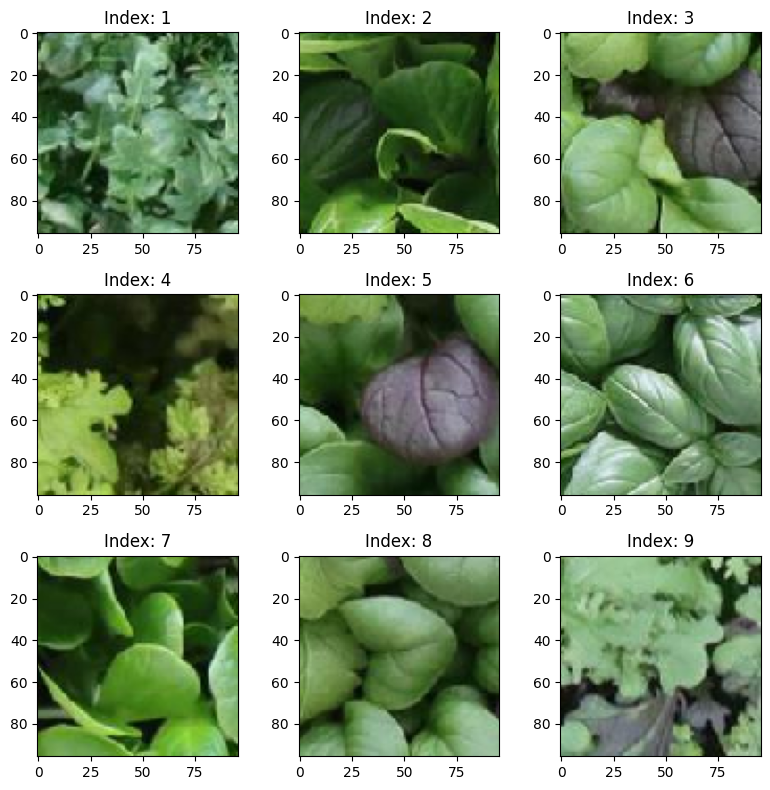

In [65]:
display_images(true_negatives)

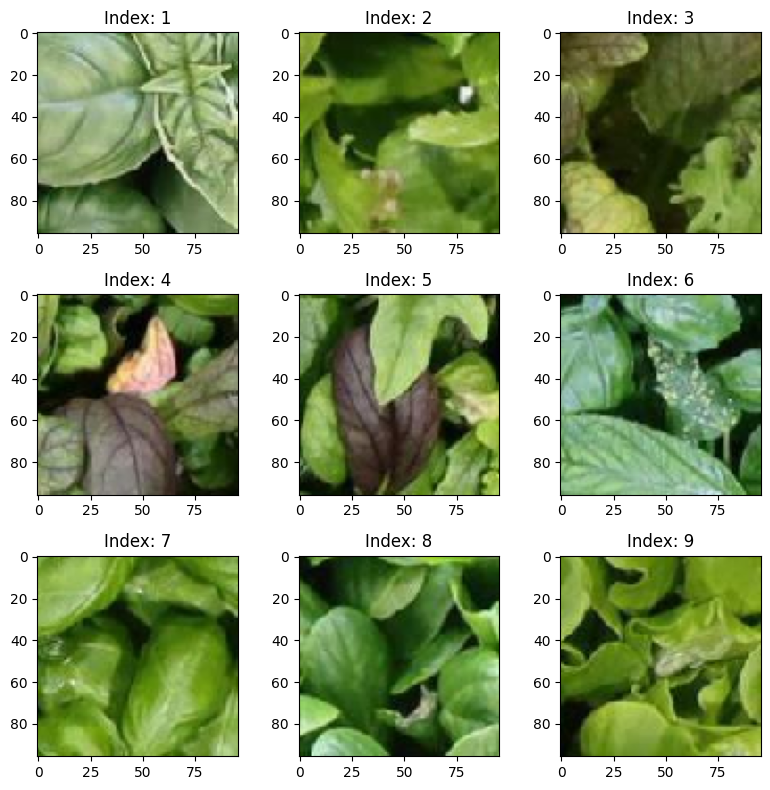

In [66]:
display_images(true_positives)

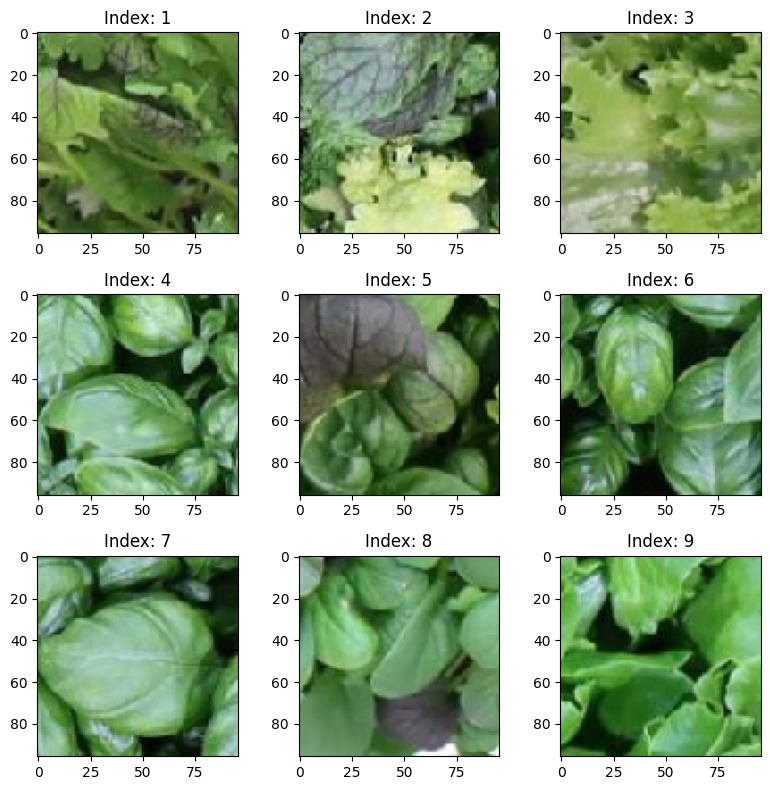

In [69]:
display_images(false_negatives)

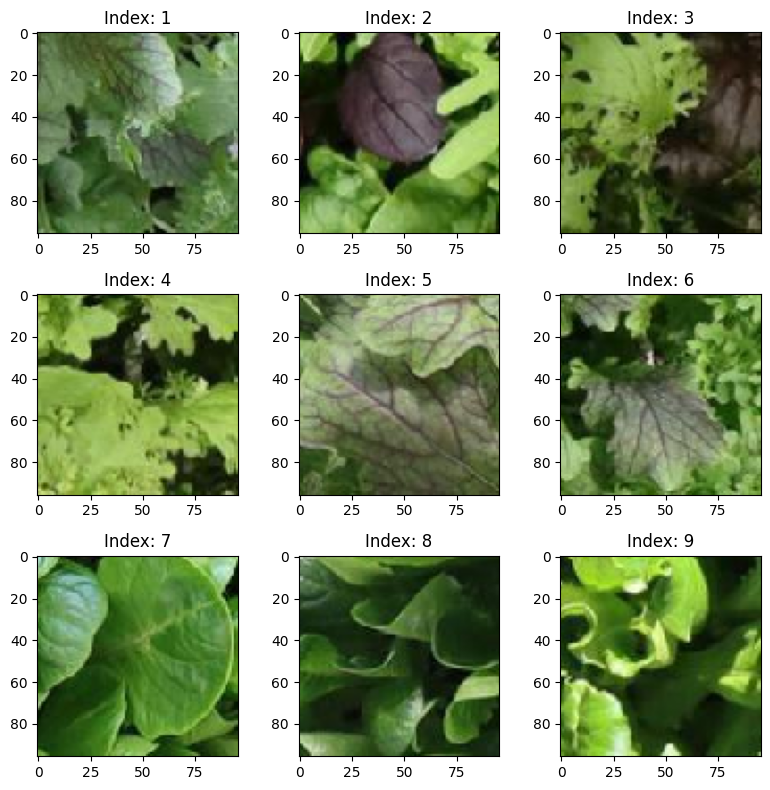

In [70]:
display_images(false_positives)